In [1]:
!nvidia-smi

Sat Jun 12 10:10:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 34%   54C    P8    11W / 250W |     11MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:D8:00.0 Off |                  N/A |
|  0%   

In [2]:
import tensorflow as tf

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
from dataset import DataGenerator

In [5]:
datagen = DataGenerator().gen_batch
dataset = tf.data.Dataset.from_generator(
     datagen,
     output_signature=(
         tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float64),
         tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float64)))

[image loader] log_path : /tf/painter/data/_log/2021-06-12-10-10-16
start /tf/painter/data/preprocessed_kaggle/train
finish
start /tf/painter/data/preprocessed_kaggle/test
finish
[image loader] log_path : /tf/painter/data/_log/2021-06-12-10-10-18
start /tf/painter/data/wikiart/Naive_Art_Primitivism
finish
start /tf/painter/data/wikiart/High_Renaissance
finish
start /tf/painter/data/wikiart/Rococo
finish
start /tf/painter/data/wikiart/Impressionism
finish
start /tf/painter/data/wikiart/Ukiyo_e
finish
start /tf/painter/data/wikiart/Pop_Art
finish
start /tf/painter/data/wikiart/Cubism
finish
start /tf/painter/data/wikiart/Fauvism
finish
start /tf/painter/data/wikiart/Expressionism
finish
start /tf/painter/data/wikiart/Pointillism
finish
start /tf/painter/data/wikiart/Minimalism
finish
start /tf/painter/data/wikiart/Synthetic_Cubism
finish
start /tf/painter/data/wikiart/Post_Impressionism
finish
start /tf/painter/data/wikiart/Northern_Renaissance
finish
start /tf/painter/data/wikiart/Baroq

In [6]:
train_dataset = dataset.batch(5)

In [7]:
train_dataset

<BatchDataset shapes: ((None, None, 256, 256, 3), (None, None, 256, 256, 3)), types: (tf.float64, tf.float64)>

In [8]:
datagen = DataGenerator().gen_sample
dataset = tf.data.Dataset.from_generator(
     datagen,
     output_signature=(
         tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float64),
         tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float64)))

[image loader] log_path : /tf/painter/data/_log/2021-06-12-10-10-21
start /tf/painter/data/preprocessed_kaggle/train
finish
start /tf/painter/data/preprocessed_kaggle/test
finish
[image loader] log_path : /tf/painter/data/_log/2021-06-12-10-10-22
start /tf/painter/data/wikiart/Naive_Art_Primitivism
finish
start /tf/painter/data/wikiart/High_Renaissance
finish
start /tf/painter/data/wikiart/Rococo
finish
start /tf/painter/data/wikiart/Impressionism
finish
start /tf/painter/data/wikiart/Ukiyo_e
finish
start /tf/painter/data/wikiart/Pop_Art
finish
start /tf/painter/data/wikiart/Cubism
finish
start /tf/painter/data/wikiart/Fauvism
finish
start /tf/painter/data/wikiart/Expressionism
finish
start /tf/painter/data/wikiart/Pointillism
finish
start /tf/painter/data/wikiart/Minimalism
finish
start /tf/painter/data/wikiart/Synthetic_Cubism
finish
start /tf/painter/data/wikiart/Post_Impressionism
finish
start /tf/painter/data/wikiart/Northern_Renaissance
finish
start /tf/painter/data/wikiart/Baroq

In [9]:
BATCH_SIZE = 4
first_gen_map_width, first_gen_map_height = (4, 4)
first_gen_map_ratio = 32
first_gen_channel = 32

In [10]:
train_dataset = dataset.batch(BATCH_SIZE)

In [11]:
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float64, tf.float64)>

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(first_gen_channel * first_gen_map_width * first_gen_map_height * first_gen_map_ratio, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((first_gen_map_width, first_gen_map_height, first_gen_channel * first_gen_map_ratio)))
    print(model.output_shape)
    assert model.output_shape == (None, first_gen_map_width, first_gen_map_height, first_gen_channel * first_gen_map_ratio) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(first_gen_channel * first_gen_map_ratio / 2, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, first_gen_map_width * 2, first_gen_map_height * 2, first_gen_channel * first_gen_map_ratio / 2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(first_gen_channel * first_gen_map_ratio / 4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, first_gen_map_width * 4, first_gen_map_height * 4, first_gen_channel * first_gen_map_ratio / 4)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(first_gen_channel * first_gen_map_ratio / 8, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, first_gen_map_width * 8, first_gen_map_height * 8, first_gen_channel * first_gen_map_ratio / 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(first_gen_channel * first_gen_map_ratio / 16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, first_gen_map_width * 16, first_gen_map_height * 16, first_gen_channel * first_gen_map_ratio / 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(first_gen_channel * first_gen_map_ratio / 32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, first_gen_map_width * 32, first_gen_map_height * 32, first_gen_channel * first_gen_map_ratio / 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, first_gen_map_width * 64, first_gen_map_height * 64, 3)

    return model

(None, 4, 4, 1024)


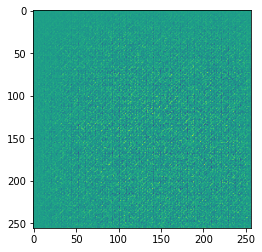

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])


In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(first_gen_channel / 2, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(first_gen_channel, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(first_gen_channel * 2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(first_gen_channel * 4, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(first_gen_channel * 8, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(first_gen_channel * 16, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-1.0426513e-05]], shape=(1, 1), dtype=float32)


In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [21]:
writer = tf.summary.create_file_writer("./mylogs")

In [22]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [24]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function(input_signature=(tf.TensorSpec(shape=[], dtype=tf.int64),tf.TensorSpec(shape=[None, 256,256,3], dtype=tf.float64)))
def train_step(step, images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with writer.as_default():
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          generated_images = generator(noise, training=True)

          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

          if tf.math.floormod(step, tf.constant(100, dtype=tf.int64)) == tf.constant(0, dtype=tf.int64):
#               tf.print(f'summaries {step}')

              tf.summary.scalar("train_gen_loss", gen_loss, step=step)
              tf.summary.scalar("train_disc_loss", disc_loss, step=step)
              tf.summary.image("train_gen_images", generated_images, step=step)
              writer_flush = writer.flush()
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [25]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [26]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    step = tf.constant(0, dtype=tf.int64)

    for idx, image_batch in enumerate(dataset):
      if idx % 100 is 0 : print(f'Run step {idx}')
      # image_batch[1] : choose zero to positive 1 range float64 image
      train_step(tf.constant(idx, dtype=tf.int64), image_batch[1])

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [ ]:
%%time
train(train_dataset, EPOCHS)


Run step 0
Instructions for updating:
Use fn_output_signature instead
Run step 100
Run step 200
Run step 300
Run step 400
Run step 500
Run step 600
Run step 700
Run step 800
Run step 900
Run step 1000
Run step 1100
Run step 1200
Run step 1300
Run step 1400
Run step 1500
Run step 1600
Run step 1700
Run step 1800
Run step 1900
Run step 2000
Run step 2100
Run step 2200
Run step 2300
Run step 2400
Run step 2500
Run step 2600
Run step 2700
Run step 2800
Run step 2900
Run step 3000
Run step 3100
Run step 3200
Run step 3300
Run step 3400
Run step 3500
Run step 3600
Run step 3700
Run step 3800
Run step 3900
Run step 4000
Run step 4100
Run step 4200
Run step 4300
Run step 4400
Run step 4500
Run step 4600
Run step 4700
Run step 4800
Run step 4900
Run step 5000
Run step 5100
Run step 5200
Run step 5300
Run step 5400
Run step 5500
Run step 5600
Run step 5700
Run step 5800
Run step 5900
Run step 6000
Run step 6100
Run step 6200
Run step 6300
Run step 6400
Run step 6500
Run step 6600
Run step 6700
R

In [ ]:
!nvidia-smi